In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 44
meniskus-urgent             40
meniskus-minor               8
cruciate-ligament-urgent     6
cruciate-ligament-minor      2
Name: count, dtype: int64


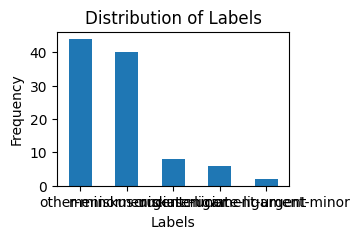

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:
model_name = "tuner"

In [4]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

2024-07-26 10:42:24.447136: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-26 10:42:24.447168: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-26 10:42:24.447182: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-26 10:42:24.447211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-26 10:42:24.447235: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model definition and training

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import HyperModel, RandomSearch

class LSTMHyperModel(HyperModel):
    def build(self, hp):
        # Define the input layer
        input_text = Input(shape=(max_length,), dtype='int32', name='text_input')
        
        # Embedding layer
        embedding = Embedding(input_dim=len(word_index), output_dim=hp.Int('embedding_dim', min_value=32, max_value=256, step=32))(input_text)
        
        # LSTM layers
        lstm_units = hp.Int('units', min_value=32, max_value=512, step=32)
        lstm_units2 = hp.Int('units', min_value=32, max_value=512, step=32)

        x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
        x = Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.8, step=0.1))(x)
        x = Bidirectional(LSTM(units=lstm_units2))(x)
        x = Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.8, step=0.1))(x)
        
        # Output layer
        output = Dense(num_classes, activation='softmax')(x)
        
        # Build and compile the model
        model = Model(inputs=input_text, outputs=output)
        model.compile(optimizer="adam", loss=loss, metrics=metrics)
        
        return model

# Set up the tuner with the RandomSearch algorithm
tuner = RandomSearch(
    LSTMHyperModel(),
    objective='val_f1_score',
    max_trials=10,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='LSTM_Classification'
)

# Search for the best hyperparameters
tuner.search(train_padded, train_labels, epochs=5, validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
for hp in best_hps.space:
    print(f"{hp.name}: {best_hps.get(hp.name)}")

Trial 10 Complete [00h 00m 11s]
val_f1_score: 0.10802918672561646

Best val_f1_score So Far: 0.10802918672561646
Total elapsed time: 00h 01m 35s
Best hyperparameters found:
embedding_dim: 64
units: 32
dropout_1: 0.0
dropout_2: 0.30000000000000004


In [6]:
save_for_evaluation(best_model, history, model_name, test_padded, test_labels, label_encoder)

NameError: name 'history' is not defined

In [ ]:
#eval_training(history, metrics)

In [ ]:
eval(best_model, test_padded, test_labels, label_encoder)